In [1]:
from __future__ import unicode_literals

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,4)

import itertools
import logging
import operator
import random
import re

import numpy as np
import pandas as pd
# from int_date import get_date_from_diff

__author__ = 'Cedric Zhuang'

log = logging.getLogger(__name__)


class StockDataFrame(pd.DataFrame):
    OPERATORS = ['le', 'ge', 'lt', 'gt', 'eq', 'ne']

    KDJ_PARAM = (2.0 / 3.0, 1.0 / 3.0)

    BOLL_PERIOD = 20
    BOLL_STD_TIMES = 2

    @staticmethod
    def _get_change(df):
        df['change'] = df['close'].pct_change() * 100
        return df['change']

    @staticmethod
    def _get_p(df, column, shifts):
        """ get the permutation of specified range

        example:
        index    x   x_-2,-1_p
        0        1         NaN
        1       -1         NaN
        2        3           2  (0.x > 0, and assigned to weight 2)
        3        5           1  (2.x > 0, and assigned to weight 1)
        4        1           3

        :param df: data frame
        :param column: the column to calculate p from
        :param shifts: the range to consider
        :return:
        """
        column_name = '{}_{}_p'.format(column, shifts)
        # initialize the column if not
        df.get(column)
        shifts = StockDataFrame.to_ints(shifts)[::-1]
        indices = None
        count = 0
        for shift in shifts:
            shifted = df.shift(-shift)
            index = (shifted[column] > 0) * (2 ** count)
            if indices is None:
                indices = index
            else:
                indices += index
            count += 1
        StockDataFrame.set_nan(indices, shifts)
        df[column_name] = indices

    @classmethod
    def to_ints(cls, shifts):
        items = map(cls._process_shifts_segment,
                    shifts.split(','))
        return sorted(list(set(itertools.chain(*items))))

    @classmethod
    def to_int(cls, shifts):
        numbers = cls.to_ints(shifts)
        if len(numbers) != 1:
            raise IndexError("only accept 1 number.")
        return numbers[0]

    @staticmethod
    def to_floats(shifts):
        floats = map(float, shifts.split(','))
        return sorted(list(set(floats)))

    @classmethod
    def to_float(cls, shifts):
        floats = cls.to_floats(shifts)
        if len(floats) != 1:
            raise IndexError('only accept 1 float.')
        return floats[0]

    @staticmethod
    def _process_shifts_segment(shift_segment):
        if '~' in shift_segment:
            start, end = shift_segment.split('~')
            shifts = range(int(start), int(end) + 1)
        else:
            shifts = [int(shift_segment)]
        return shifts

    @staticmethod
    def set_nan(pd_obj, shift):
        try:
            iter(shift)
            max_shift = max(shift)
            min_shift = min(shift)
            StockDataFrame._set_nan_of_single_shift(pd_obj, max_shift)
            StockDataFrame._set_nan_of_single_shift(pd_obj, min_shift)
        except TypeError:
            # shift is not iterable
            StockDataFrame._set_nan_of_single_shift(pd_obj, shift)

    @staticmethod
    def _set_nan_of_single_shift(pd_obj, shift):
        val = np.nan
        if shift > 0:
            pd_obj.iloc[-shift:] = val
        elif shift < 0:
            pd_obj.iloc[:-shift] = val

    @classmethod
    def _get_r(cls, df, column, shifts):
        """ Get rate of change of column

        :param df: DataFrame object
        :param column: column name of the rate to calculate
        :param shifts: days to shift, accept one shift only
        :return: None
        """
        shift = cls.to_int(shifts)
        rate_key = '{}_{}_r'.format(column, shift)
        df[rate_key] = df[column].pct_change(periods=-shift) * 100

    @classmethod
    def _get_s(cls, df, column, shifts):
        """ Get the column shifted by days

        :param df: DataFrame object
        :param column: name of the column to shift
        :param shifts: days to shift, accept one shift only
        :return: None
        """
        shift = cls.to_int(shifts)
        shifted_key = "{}_{}_s".format(column, shift)
        df[shifted_key] = df[column].shift(-shift)
        StockDataFrame.set_nan(df[shifted_key], shift)

    @classmethod
    def _get_log_ret(cls, df):
        df['log-ret'] = np.log(df['close'] / df['close_-1_s'])

    @classmethod
    def _get_c(cls, df, column, shifts):
        """ get the count of column in range (shifts)

        example: kdjj_0_le_20_c
        :param df: stock data
        :param column: column name
        :param shifts: range to count, only to previous
        :return:
        """
        column_name = '{}_{}_{}'.format(column, shifts, 'c')
        shifts = abs(cls.to_int(shifts))
        df[column_name] = df[column].rolling(
            center=False, window=shifts).apply(np.count_nonzero)

    @classmethod
    def _get_op(cls, df, column, threshold, op):
        column_name = '{}_{}_{}'.format(column, threshold, op)
        threshold = cls.to_float(threshold)
        f = getattr(operator, op)
        df[column_name] = f(df[column], threshold)

    @staticmethod
    def get_diff_convolve_array(shift):
        if shift == 0:
            ret = [1]
        else:
            ret = np.zeros(abs(shift) + 1)
            if shift < 0:
                ret[[0, -1]] = 1, -1
            else:
                ret[[0, -1]] = -1, 1
        return ret

    @classmethod
    def _init_shifted_columns(cls, column, df, shifts):
        # initialize the column if not
        df.get(column)
        shifts = cls.to_ints(shifts)
        shift_column_names = ['{}_{}_s'.format(column, shift) for shift in
                              shifts]
        [df.get(name) for name in shift_column_names]
        return shift_column_names

    @classmethod
    def _get_max(cls, df, column, shifts):
        column_name = '{}_{}_max'.format(column, shifts)
        shift_column_names = cls._init_shifted_columns(column, df, shifts)
        df[column_name] = np.max(df[shift_column_names], axis=1)

    @classmethod
    def _get_min(cls, df, column, shifts):
        column_name = '{}_{}_min'.format(column, shifts)
        shift_column_names = cls._init_shifted_columns(column, df, shifts)
        df[column_name] = np.min(df[shift_column_names], axis=1)

    @staticmethod
    def _get_rsv(df, n_days):
        """ Calculate the RSV (Raw Stochastic Value) within N days

        This value is essential for calculating KDJs
        Current day is included in N
        :param df: data
        :param n_days: N days
        :return: None
        """
        n_days = int(n_days)
        column_name = 'rsv_{}'.format(n_days)
        low_min = df['low'].rolling(
            min_periods=1, window=n_days, center=False).min()
        high_max = df['high'].rolling(
            min_periods=1, window=n_days, center=False).max()

        cv = (df['close'] - low_min) / (high_max - low_min)
        df[column_name] = cv.fillna(0).astype('float64') * 100

    @staticmethod
    def _positive_sum(data):
        data = [i if i > 0 else 0 for i in data]
        ret = data[0]
        for i in data[1:]:
            ret = (ret * (len(data) - 1) + i) / len(data)
        return ret

    @staticmethod
    def _negative_sum(data):
        data = [-i if i < 0 else 0 for i in data]
        ret = data[0]
        for i in data[1:]:
            ret = (ret * (len(data) - 1) + i) / len(data)
        return ret

    # noinspection PyUnresolvedReferences
    @classmethod
    def _get_rsi(cls, df, n_days):
        """ Calculate the RSI (Relative Strength Index) within N days

        calculated based on the formula at:
        https://en.wikipedia.org/wiki/Relative_strength_index

        :param df: data
        :param n_days: N days
        :return: None
        """
        n_days = int(n_days)
        d = df['close_-1_d']

        df['closepm'] = (d + d.abs()) / 2
        df['closenm'] = (-d + d.abs()) / 2
        closepm_smma_column = 'closepm_{}_smma'.format(n_days)
        closenm_smma_column = 'closenm_{}_smma'.format(n_days)
        p_ema = df[closepm_smma_column]
        n_ema = df[closenm_smma_column]

        rs_column_name = 'rs_{}'.format(n_days)
        rsi_column_name = 'rsi_{}'.format(n_days)
        df[rs_column_name] = rs = p_ema / n_ema
        df[rsi_column_name] = 100 - 100 / (1.0 + rs)

        del df['closepm']
        del df['closenm']
        del df[closepm_smma_column]
        del df[closenm_smma_column]

    @classmethod
    def _get_smma(cls, df, column, windows):
        """ get smoothed moving average.

        :param df: data
        :param windows: range
        :return: result series
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = '{}_{}_smma'.format(column, window)
        smma = df[column].ewm(
            ignore_na=False, alpha=1.0 / window,
            min_periods=0, adjust=True).mean()
        df[column_name] = smma
        return smma

    @classmethod
    def _get_trix(cls, df, column=None, windows=None):
        if column is None and windows is None:
            column_name = 'trix'
        else:
            column_name = '{}_{}_trix'.format(column, windows)

        if column is None:
            column = 'close'
        if windows is None:
            windows = 12
        window = cls.get_only_one_positive_int(windows)

        single = '{c}_{w}_ema'.format(c=column, w=window)
        double = '{c}_{w}_ema_{w}_ema'.format(c=column, w=window)
        triple = '{c}_{w}_ema_{w}_ema_{w}_ema'.format(c=column, w=window)
        df['ema3'] = df[triple]
        prev_ema3 = df['ema3_-1_s']
        df[column_name] = (df['ema3'] - prev_ema3) * 100 / prev_ema3

        del df[single]
        del df[double]
        del df[triple]
        del df['ema3']
        del df['ema3_-1_s']

    @classmethod
    def _get_wr(cls, df, n_days):
        """ Williams Overbought/Oversold Index

        WMS=[(Hn—Ct)/(Hn—Ln)] ×100
        Ct - the close price
        Hn - N days high
        Ln - N days low

        :param df: data
        :param n_days: N days
        :return: None
        """
        n_days = int(n_days)
        ln = df['low'].rolling(min_periods=1, window=n_days,
                               center=False).min()

        hn = df['high'].rolling(min_periods=1, window=n_days,
                                center=False).max()
        column_name = 'wr_{}'.format(n_days)
        df[column_name] = (hn - df['close']) / (hn - ln) * 100

    @classmethod
    def _get_cci(cls, df, n_days=None):
        """ Commodity Channel Index

        CCI = (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
        Typical Price (TP) = (High + Low + Close)/3
        TP is also implemented as 'middle'.

        :param df: data
        :param n_days: N days window
        :return: None
        """
        if n_days is None:
            n_days = 14
            column_name = 'cci'
        else:
            n_days = int(n_days)
            column_name = 'cci_{}'.format(n_days)

        tp = df['middle']
        tp_sma = df['middle_{}_sma'.format(n_days)]
        md = df['middle'].rolling(
            min_periods=1, center=False, window=n_days).apply(
            lambda x: np.fabs(x - x.mean()).mean())

        df[column_name] = (tp - tp_sma) / (.015 * md)

    @classmethod
    def _get_tr(cls, df):
        """ True Range of the trading

        tr = max[(high - low), abs(high - close_prev), abs(low - close_prev)]
        :param df: data
        :return: None
        """
        prev_close = df['close_-1_s']
        high = df['high']
        low = df['low']
        c1 = high - low
        c2 = np.abs(high - prev_close)
        c3 = np.abs(low - prev_close)
        df['tr'] = np.max((c1, c2, c3), axis=0)

    @classmethod
    def _get_atr(cls, df, window=None):
        """ Average True Range

        The average true range is an N-day smoothed moving average (SMMA) of
        the true range values.  Default to 14 days.
        https://en.wikipedia.org/wiki/Average_true_range

        :param df: data
        :return: None
        """
        if window is None:
            window = 14
            column_name = 'atr'
        else:
            window = int(window)
            column_name = 'atr_{}'.format(window)
        tr_smma_column = 'tr_{}_smma'.format(window)

        df[column_name] = df[tr_smma_column]
        del df[tr_smma_column]

    @classmethod
    def _get_dma(cls, df):
        """ Different of Moving Average

        default to 10 and 50.
        :param df: data
        :return: None
        """
        df['dma'] = df['close_10_sma'] - df['close_50_sma']

    @classmethod
    def _get_dmi(cls, df):
        """ get the default setting for DMI

        including:
        +DI: 14 days SMMA of +DM,
        -DI: 14 days SMMA of -DM,
        DX: based on +DI and -DI
        ADX: 6 days SMMA of DX
        :param df: data
        :return:
        """
        df['pdi'] = cls._get_pdi(df, 14)
        df['mdi'] = cls._get_mdi(df, 14)
        df['dx'] = cls._get_dx(df, 14)
        df['adx'] = df['dx_6_ema']
        df['adxr'] = df['adx_6_ema']

    @classmethod
    def _get_um_dm(cls, df):
        """ Up move and down move

        initialize up move and down move
        :param df: data
        """
        hd = df['high_delta']
        df['um'] = (hd + hd.abs()) / 2
        ld = -df['low_delta']
        df['dm'] = (ld + ld.abs()) / 2

    @classmethod
    def _get_pdm(cls, df, windows):
        """ +DM, positive directional moving

        If window is not 1, calculate the SMMA of +DM
        :param df: data
        :param windows: range
        :return:
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = 'pdm_{}'.format(window)
        um, dm = df['um'], df['dm']
        df['pdm'] = np.where(um > dm, um, 0)
        if window > 1:
            pdm = df['pdm_{}_ema'.format(window)]
        else:
            pdm = df['pdm']
        df[column_name] = pdm

    @classmethod
    def _get_vr(cls, df, windows=None):
        if windows is None:
            window = 26
            column_name = 'vr'
        else:
            window = cls.get_only_one_positive_int(windows)
            column_name = 'vr_{}'.format(window)

        df['av'] = np.where(df['change'] > 0, df['volume'], 0)
        avs = df['av'].rolling(
            min_periods=1, window=window, center=False).sum()

        df['bv'] = np.where(df['change'] < 0, df['volume'], 0)
        bvs = df['bv'].rolling(
            min_periods=1, window=window, center=False).sum()

        df['cv'] = np.where(df['change'] == 0, df['volume'], 0)
        cvs = df['cv'].rolling(
            min_periods=1, window=window, center=False).sum()

        df[column_name] = (avs + cvs / 2) / (bvs + cvs / 2) * 100
        del df['av']
        del df['bv']
        del df['cv']

    @classmethod
    def _get_mdm(cls, df, windows):
        """ -DM, negative directional moving accumulation

        If window is not 1, return the SMA of -DM.
        :param df: data
        :param windows: range
        :return:
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = 'mdm_{}'.format(window)
        um, dm = df['um'], df['dm']
        df['mdm'] = np.where(dm > um, dm, 0)
        if window > 1:
            mdm = df['mdm_{}_ema'.format(window)]
        else:
            mdm = df['mdm']
        df[column_name] = mdm

    @classmethod
    def _get_pdi(cls, df, windows):
        """ +DI, positive directional moving index

        :param df: data
        :param windows: range
        :return:
        """
        window = cls.get_only_one_positive_int(windows)
        pdm_column = 'pdm_{}'.format(window)
        tr_column = 'atr_{}'.format(window)
        pdi_column = 'pdi_{}'.format(window)
        df[pdi_column] = df[pdm_column] / df[tr_column] * 100
        return df[pdi_column]

    @classmethod
    def _get_mdi(cls, df, windows):
        window = cls.get_only_one_positive_int(windows)
        mdm_column = 'mdm_{}'.format(window)
        tr_column = 'atr_{}'.format(window)
        mdi_column = 'mdi_{}'.format(window)
        df[mdi_column] = df[mdm_column] / df[tr_column] * 100
        return df[mdi_column]

    @classmethod
    def _get_dx(cls, df, windows):
        window = cls.get_only_one_positive_int(windows)
        dx_column = 'dx_{}'.format(window)
        mdi_column = 'mdi_{}'.format(window)
        pdi_column = 'pdi_{}'.format(window)
        mdi, pdi = df[mdi_column], df[pdi_column]
        df[dx_column] = abs(pdi - mdi) / (pdi + mdi) * 100
        return df[dx_column]

    @classmethod
    def _get_kdj_default(cls, df):
        """ default KDJ, 9 days

        :param df: k line data frame
        :return: None
        """
        df['kdjk'] = df['kdjk_9']
        df['kdjd'] = df['kdjd_9']
        df['kdjj'] = df['kdjj_9']

    @classmethod
    def _get_cr(cls, df, window=26):
        ym = df['middle_-1_s']
        h = df['high']
        p1_m = df.loc[:, ['middle_-1_s', 'high']].min(axis=1)
        p2_m = df.loc[:, ['middle_-1_s', 'low']].min(axis=1)
        p1 = (h - p1_m).rolling(
            min_periods=1, window=window, center=False).sum()
        p2 = (ym - p2_m).rolling(
            min_periods=1, window=window, center=False).sum()
        df['cr'] = p1 / p2 * 100
        del df['middle_-1_s']
        df['cr-ma1'] = cls._shifted_cr_sma(df, 5)
        df['cr-ma2'] = cls._shifted_cr_sma(df, 10)
        df['cr-ma3'] = cls._shifted_cr_sma(df, 20)

    @classmethod
    def _shifted_cr_sma(cls, df, window):
        name = cls._temp_name()
        df[name] = df['cr'].rolling(min_periods=1, window=window,
                                    center=False).mean()
        to_shift = '{}_-{}_s'.format(name, int(window / 2.5 + 1))
        ret = df[to_shift]
        del df[name], df[to_shift]
        return ret

    @classmethod
    def _temp_name(cls):
        return 'sdf{}'.format(random.randint(0, 10e8))

    @classmethod
    def _get_middle(cls, df):
        df['middle'] = (df['close'] + df['high'] + df['low']) / 3.0

    @classmethod
    def _calc_kd(cls, column):
        param0, param1 = cls.KDJ_PARAM
        k = 50.0
        # noinspection PyTypeChecker
        for i in param1 * column:
            k = param0 * k + i
            yield k

    @classmethod
    def _get_kdjk(cls, df, n_days):
        """ Get the K of KDJ

        K ＝ 2/3 × (prev. K) +1/3 × (curr. RSV)
        2/3 and 1/3 are the smooth parameters.
        :param df: data
        :param n_days: calculation range
        :return: None
        """
        rsv_column = 'rsv_{}'.format(n_days)
        k_column = 'kdjk_{}'.format(n_days)
        df[k_column] = list(cls._calc_kd(df.get(rsv_column)))

    @classmethod
    def _get_kdjd(cls, df, n_days):
        """ Get the D of KDJ

        D = 2/3 × (prev. D) +1/3 × (curr. K)
        2/3 and 1/3 are the smooth parameters.
        :param df: data
        :param n_days: calculation range
        :return: None
        """
        k_column = 'kdjk_{}'.format(n_days)
        d_column = 'kdjd_{}'.format(n_days)
        df[d_column] = list(cls._calc_kd(df.get(k_column)))

    @staticmethod
    def _get_kdjj(df, n_days):
        """ Get the J of KDJ

        J = 3K-2D
        :param df: data
        :param n_days: calculation range
        :return: None
        """
        k_column = 'kdjk_{}'.format(n_days)
        d_column = 'kdjd_{}'.format(n_days)
        j_column = 'kdjj_{}'.format(n_days)
        df[j_column] = 3 * df[k_column] - 2 * df[d_column]

    @staticmethod
    def remove_random_nan(pd_obj):
        return pd_obj.where((pd.notnull(pd_obj)), None)

    @staticmethod
    def _get_d(df, column, shifts):
        shift = StockDataFrame.to_int(shifts)
        shift_column = '{}_{}_s'.format(column, shift)
        column_name = '{}_{}_d'.format(column, shift)
        df[column_name] = df[column] - df[shift_column]
        StockDataFrame.set_nan(df[column_name], shift)

    @classmethod
    def _get_sma(cls, df, column, windows):
        """ get simple moving average

        :param df: data
        :param column: column to calculate
        :param windows: collection of window of simple moving average
        :return: None
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = '{}_{}_sma'.format(column, window)
        df[column_name] = df[column].rolling(min_periods=1, window=window,
                                             center=False).mean()

    @classmethod
    def _get_ema(cls, df, column, windows):
        """ get exponential moving average

        :param df: data
        :param column: column to calculate
        :param windows: collection of window of exponential moving average
        :return: None
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = '{}_{}_ema'.format(column, window)
        if len(df[column]) > 0:
            df[column_name] = df[column].ewm(
                ignore_na=False, span=window,
                min_periods=0, adjust=True).mean()
        else:
            df[column_name] = []

    @classmethod
    def _get_boll(cls, df):
        """ Get Bollinger bands.

        boll_ub means the upper band of the Bollinger bands
        boll_lb means the lower band of the Bollinger bands
        boll_ub = MA + Kσ
        boll_lb = MA − Kσ
        M = BOLL_PERIOD
        K = BOLL_STD_TIMES
        :param df: data
        :return: None
        """
        moving_avg = df['close_{}_sma'.format(cls.BOLL_PERIOD)]
        moving_std = df['close_{}_mstd'.format(cls.BOLL_PERIOD)]
        df['boll'] = moving_avg
        moving_avg = list(map(np.float64, moving_avg))
        moving_std = list(map(np.float64, moving_std))
        # noinspection PyTypeChecker
        df['boll_ub'] = np.add(moving_avg,
                               np.multiply(cls.BOLL_STD_TIMES, moving_std))
        # noinspection PyTypeChecker
        df['boll_lb'] = np.subtract(moving_avg,
                                    np.multiply(cls.BOLL_STD_TIMES,
                                                moving_std))

    @staticmethod
    def _get_macd(df):
        """ Moving Average Convergence Divergence

        This function will initialize all following columns.

        MACD Line (macd): (12-day EMA - 26-day EMA)
        Signal Line (macds): 9-day EMA of MACD Line
        MACD Histogram (macdh): MACD Line - Signal Line
        :param df: data
        :return: None
        """
        fast = df['close_12_ema']
        slow = df['close_26_ema']
        df['macd'] = fast - slow
        df['macds'] = df['macd_9_ema']
        df['macdh'] = (df['macd'] - df['macds'])
        log.critical("NOTE: Behavior of MACDH calculation has changed as of "
                     "July 2017 - it is now 1/2 of previous calculated values")
        del df['macd_9_ema']
        del fast
        del slow

    @classmethod
    def get_only_one_positive_int(cls, windows):
        if isinstance(windows, int):
            window = windows
        else:
            window = cls.to_int(windows)
            if window <= 0:
                raise IndexError("window must be greater than 0")
        return window

    @classmethod
    def _get_mstd(cls, df, column, windows):
        """ get moving standard deviation

        :param df: data
        :param column: column to calculate
        :param windows: collection of window of moving standard deviation
        :return: None
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = '{}_{}_mstd'.format(column, window)
        df[column_name] = df[column].rolling(min_periods=1, window=window,
                                             center=False).std()

    @classmethod
    def _get_mvar(cls, df, column, windows):
        """ get moving variance

        :param df: data
        :param column: column to calculate
        :param windows: collection of window of moving variance
        :return: None
        """
        window = cls.get_only_one_positive_int(windows)
        column_name = '{}_{}_mvar'.format(column, window)
        df[column_name] = df[column].rolling(
            min_periods=1, window=window, center=False).var()

    @staticmethod
    def parse_column_name(name):
        m = re.match('(.*)_([\d\-\+~,\.]+)_(\w+)', name)
        ret = [None, None, None]
        if m is None:
            m = re.match('(.*)_([\d\-\+~,]+)', name)
            if m is not None:
                ret = m.group(1, 2)
                ret = ret + (None,)
        else:
            ret = m.group(1, 2, 3)
        return ret

    CROSS_COLUMN_MATCH_STR = '(.+)_(x|xu|xd)_(.+)'

    @classmethod
    def is_cross_columns(cls, name):
        return re.match(cls.CROSS_COLUMN_MATCH_STR, name) is not None

    @classmethod
    def parse_cross_column(cls, name):
        m = re.match(cls.CROSS_COLUMN_MATCH_STR, name)
        ret = [None, None, None]
        if m is not None:
            ret = m.group(1, 2, 3)
        return ret

    @staticmethod
    def _get_rate(df):
        """ same as percent

        :param df: data frame
        :return: None
        """
        df['rate'] = df['close'].pct_change() * 100

    @staticmethod
    def _get_delta(df, key):
        key_to_delta = key.replace('_delta', '')
        df[key] = df[key_to_delta].diff()
        return df[key]

    @staticmethod
    def _get_cross(df, key):
        left, op, right = StockDataFrame.parse_cross_column(key)
        lt_series = df[left] > df[right]
        # noinspection PyTypeChecker
        different = np.zeros_like(lt_series)
        if len(different) > 1:
            # noinspection PyTypeChecker
            different[1:] = np.diff(lt_series)
            different[0] = False
        if op == 'x':
            df[key] = different
        elif op == 'xu':
            df[key] = different & lt_series
        elif op == 'xd':
            df[key] = different & ~lt_series
        return df[key]

    @staticmethod
    def init_columns(obj, columns):
        if isinstance(columns, list):
            for column in columns:
                StockDataFrame.__init_column(obj, column)
        else:
            StockDataFrame.__init_column(obj, columns)

    @classmethod
    def __init_not_exist_column(cls, df, key):
        if key == 'change':
            cls._get_change(df)
        elif key == 'rate':
            cls._get_rate(df)
        elif key == 'middle':
            cls._get_middle(df)
        elif key in ['boll', 'boll_ub', 'boll_lb']:
            cls._get_boll(df)
        elif key in ['macd', 'macds', 'macdh']:
            cls._get_macd(df)
        elif key in ['kdjk', 'kdjd', 'kdjj']:
            cls._get_kdj_default(df)
        elif key in ['cr', 'cr-ma1', 'cr-ma2', 'cr-ma3']:
            cls._get_cr(df)
        elif key in ['cci']:
            cls._get_cci(df)
        elif key in ['tr']:
            cls._get_tr(df)
        elif key in ['atr']:
            cls._get_atr(df)
        elif key in ['um', 'dm']:
            cls._get_um_dm(df)
        elif key in ['pdi', 'mdi', 'dx', 'adx', 'adxr']:
            cls._get_dmi(df)
        elif key in ['trix']:
            cls._get_trix(df)
        elif key in ['vr']:
            cls._get_vr(df)
        elif key in ['dma']:
            cls._get_dma(df)
        elif key == 'log-ret':
            cls._get_log_ret(df)
        elif key.endswith('_delta'):
            cls._get_delta(df, key)
        elif cls.is_cross_columns(key):
            cls._get_cross(df, key)
        else:
            c, r, t = cls.parse_column_name(key)
            if t is not None:
                if t in cls.OPERATORS:
                    # support all kinds of compare operators
                    cls._get_op(df, c, r, t)
                else:
                    func_name = '_get_{}'.format(t)
                    getattr(cls, func_name)(df, c, r)
            else:
                func_name = '_get_{}'.format(c)
                getattr(cls, func_name)(df, r)

    @staticmethod
    def __init_column(df, key):
        if key not in df:
            if len(df) == 0:
                df[key] = []
            else:
                StockDataFrame.__init_not_exist_column(df, key)

    def __getitem__(self, item):
        try:
            result = self.retype(
                super(StockDataFrame, self).__getitem__(item))
        except KeyError:
            try:
                self.init_columns(self, item)
            except AttributeError:
                log.exception('{} not found.'.format(item))
            result = self.retype(
                super(StockDataFrame, self).__getitem__(item))
        return result

#     def in_date_delta(self, delta_day, anchor=None):
#         if anchor is None:
#             anchor = self.get_today()
#         other_day = get_date_from_diff(anchor, delta_day)
#         if delta_day > 0:
#             start, end = anchor, other_day
#         else:
#             start, end = other_day, anchor
#         return self.retype(self.ix[start:end])

    def till(self, end_date):
        return self[self.index <= end_date]

    def start_from(self, start_date):
        return self[self.index >= start_date]

    def within(self, start_date, end_date):
        return self.start_from(start_date).till(end_date)

    def copy(self, deep=True):
        return self.retype(super(StockDataFrame, self).copy(deep))

    @staticmethod
    def retype(value, index_column=None):
        """ if the input is a `DataFrame`, convert it to this class.

        :param index_column: the column that will be used as index,
                             default to `date`
        :param value: value to convert
        :return: this extended class
        """
        if index_column is None:
            index_column = 'date'

        if isinstance(value, pd.DataFrame):
            # use all lower case for column name
            value.columns = map(lambda c: c.lower(), value.columns)

            if index_column in value.columns:
                value.set_index(index_column, inplace=True)
            value = StockDataFrame(value)
        return value

In [2]:
import pandas as pd
# load data
df0 = pd.read_csv('trades_BitBay.csv', index_col=0, usecols=['date','price', 'type', 'amount'], header=0, engine='python')
df0.index = pd.to_datetime(df0.index, unit='s')
print(df0.tail(5))

                        price  type    amount
date                                         
2017-12-27 15:10:50  56432.62  sell  0.075515
2017-12-27 15:10:54  57000.00   buy  0.028942
2017-12-27 15:10:54  56999.00   buy  0.000883
2017-12-27 15:10:58  56600.00   buy  0.001584
2017-12-27 15:10:59  56409.41  sell  0.037788


In [3]:
import numpy as np
frequency = '1H'

def sma(df, window):
    return df['close'].rolling(window=window).mean()

def resample_df(df, frequency = '1H', window1 = 6, window2 = 40):
    # resample and extract features
    one_hot = pd.get_dummies(df['type'])
    # df = df.drop('type', axis=1)
    df = df.join(one_hot)

#     print(df.tail(5))

    df_pv = df.resample(frequency).agg({'price': np.mean, 'amount': np.sum, 'buy': np.sum, 'sell': np.sum})
    df_ohlc = df['price'].resample(frequency).ohlc()

    df = pd.concat([df_pv, df_ohlc], axis=1)
    df = df.fillna(method='pad')
    df = df.dropna()
#     print(df.tail(5))


    df['sma_short'] = df['close'].rolling(window=window1).mean()
    df['sma_long'] = df['close'].rolling(window=window2).mean()
    df['action'] = df['price'].fillna(0)

    stock = StockDataFrame.retype(df)
    df['adx'] = stock['adx']
    
    return df

df = resample_df(df0, frequency)


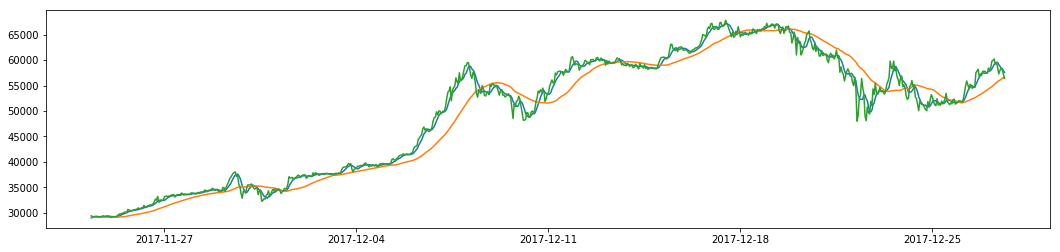

In [4]:
plt.plot(df['sma_short'][-800:])
plt.plot(df['sma_long'][-800:])
plt.plot(df['close'][-800:])
plt.show()

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
6.0
0.538908032473


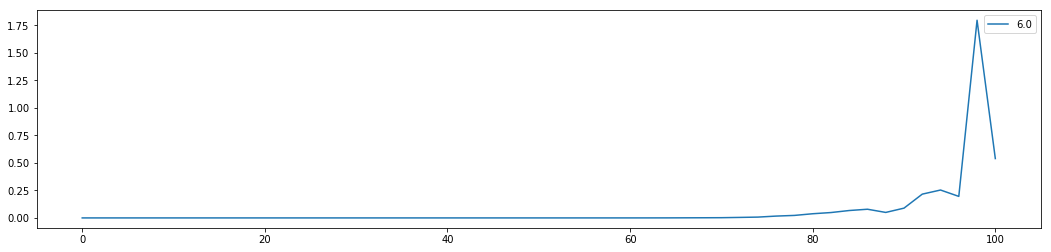

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
12.0
0.538908032473


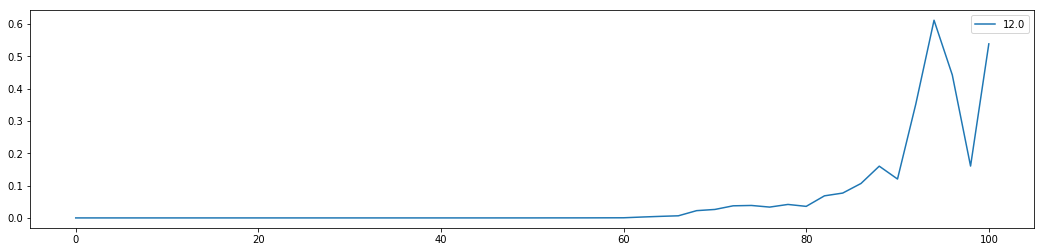

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
18.0
0.538908032473


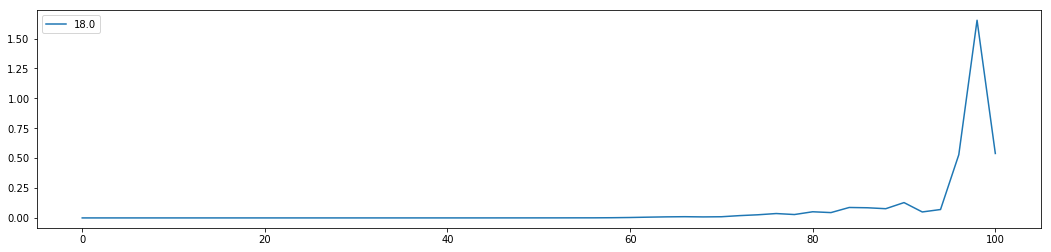

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
24.0
0.538908032473


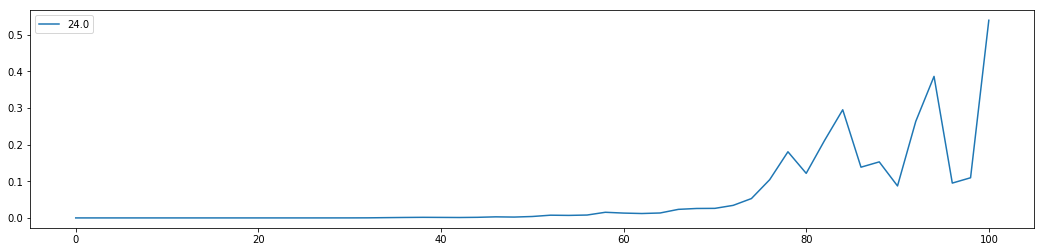

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
30.0
0.538908032473


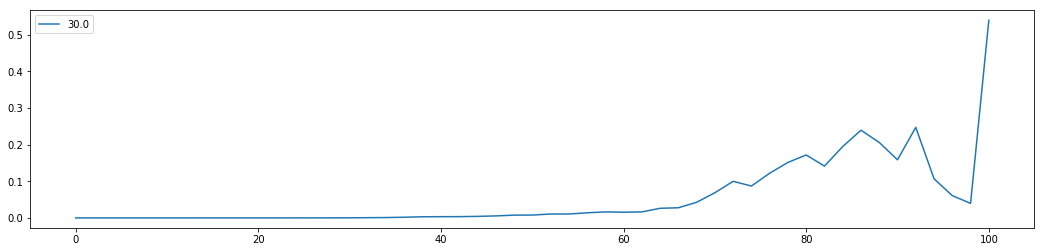

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
36.0
0.538908032473


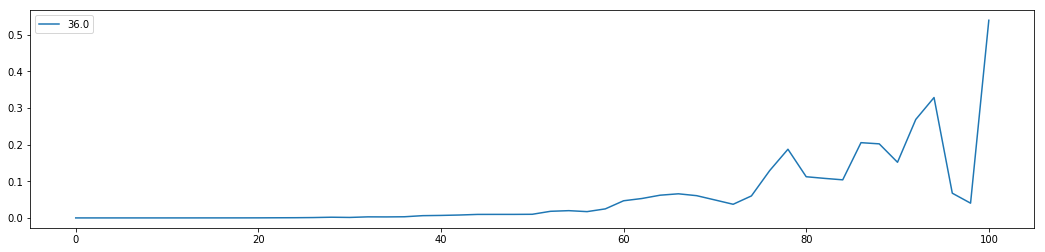

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
42.0
0.538908032473


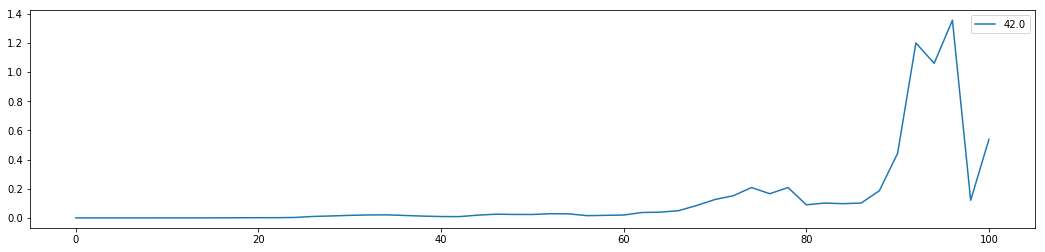

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
48.0
0.538908032473


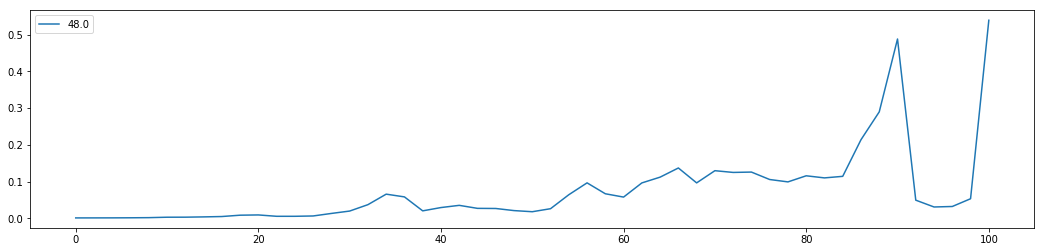

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
54.0
0.538908032473


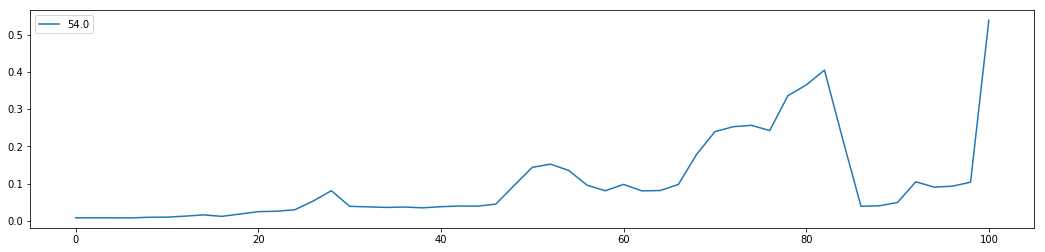

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
60.0
0.538908032473


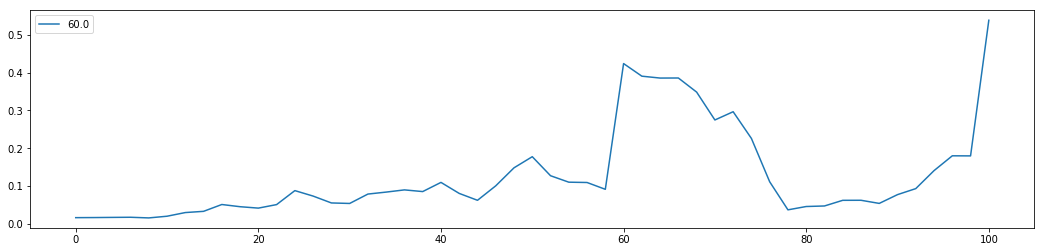

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
66.0
0.538908032473


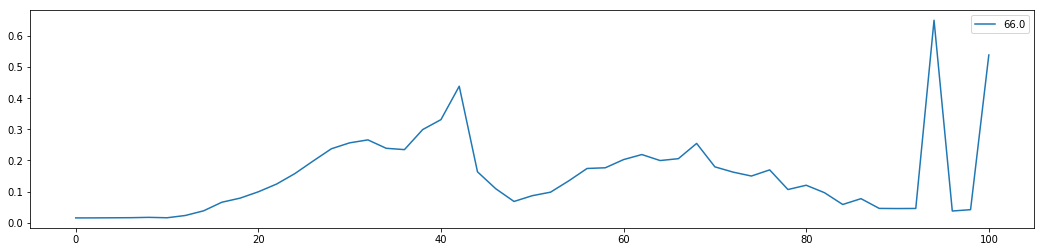

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
72.0
0.538908032473


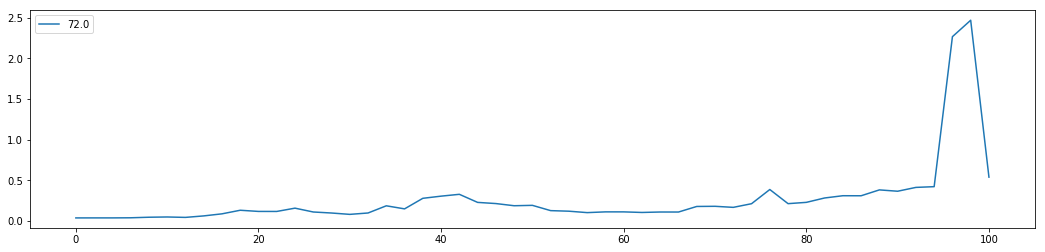

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
78.0
0.538908032473


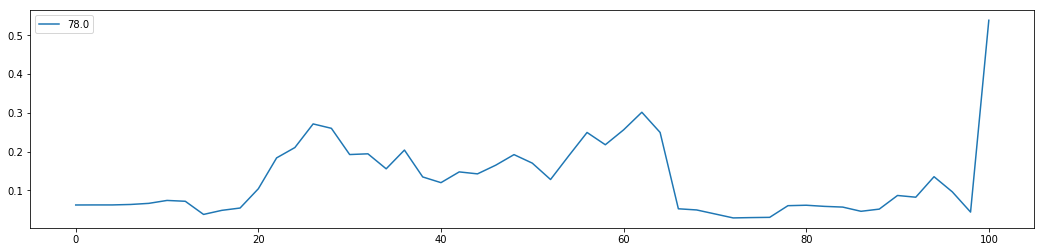

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
84.0
0.538908032473


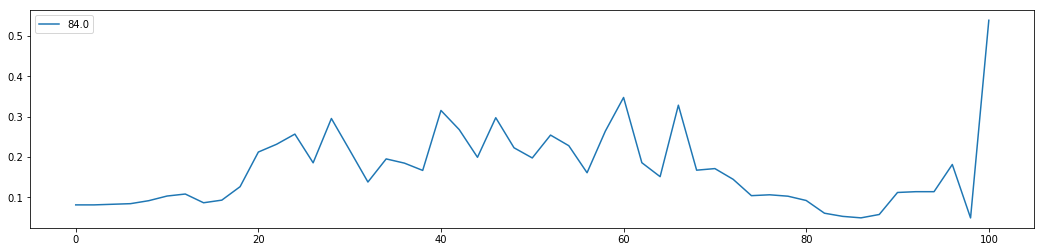

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
90.0
0.538908032473


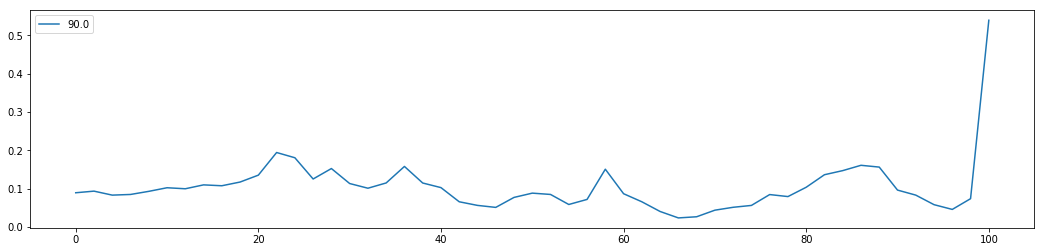

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
96.0
0.538908032473


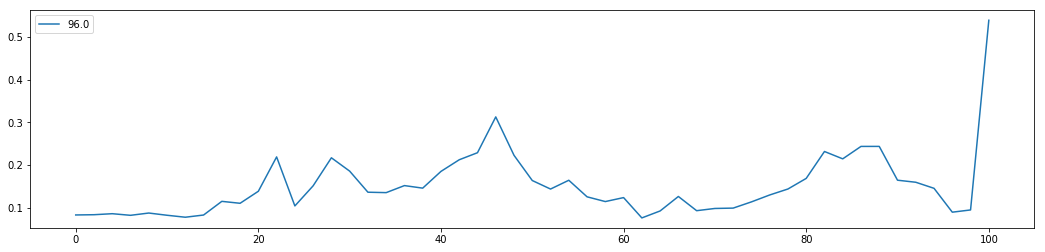

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
102.0
0.538908032473


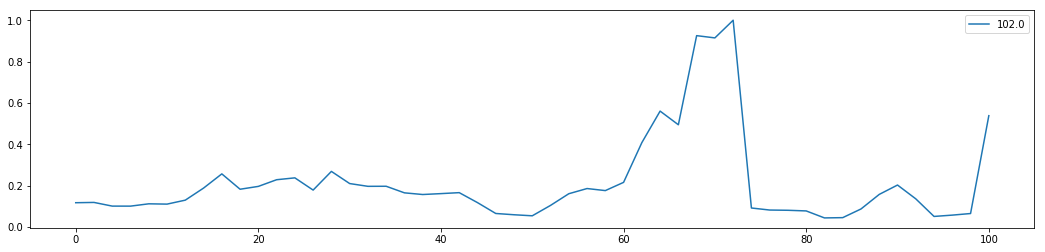

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
108.0
0.538908032473


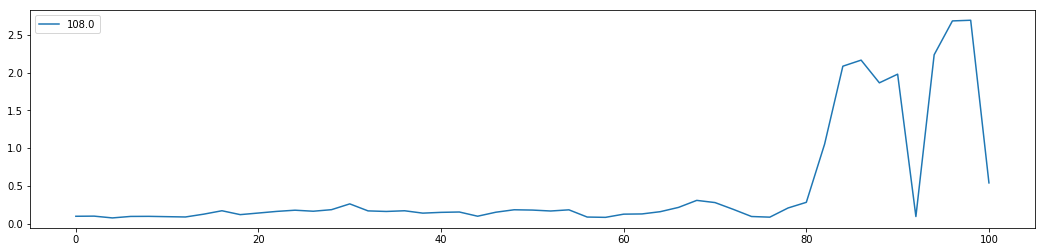

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
114.0
0.538908032473


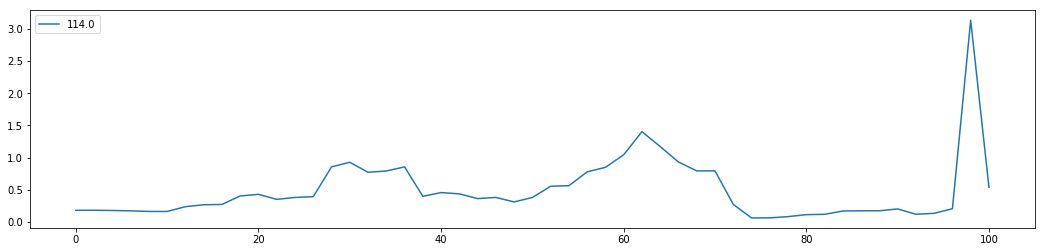

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
120.0
0.538908032473


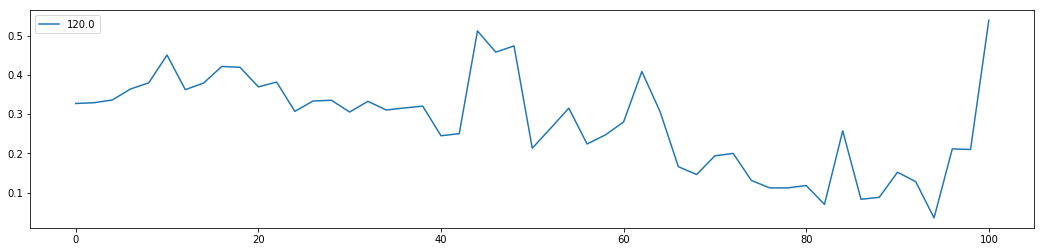

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
126.0
0.538908032473


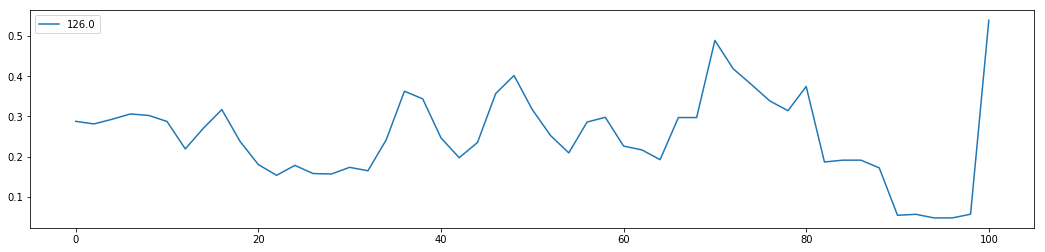

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
132.0
0.538908032473


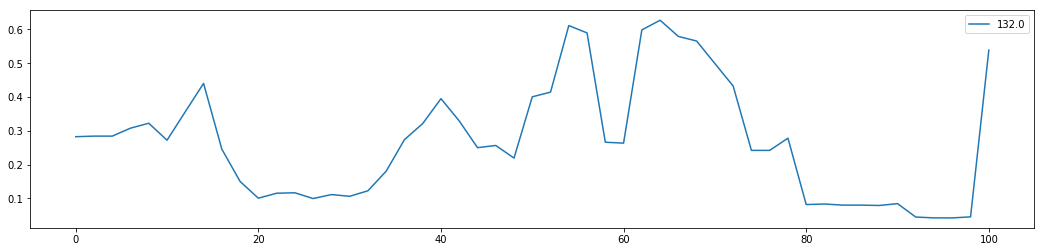

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
138.0
0.538908032473


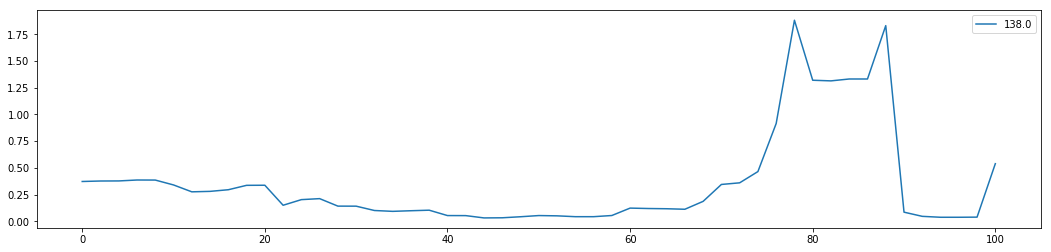

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
144.0
0.538908032473


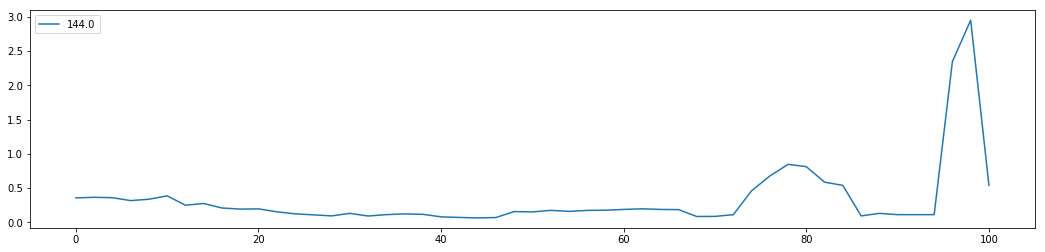

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
150.0
0.538908032473


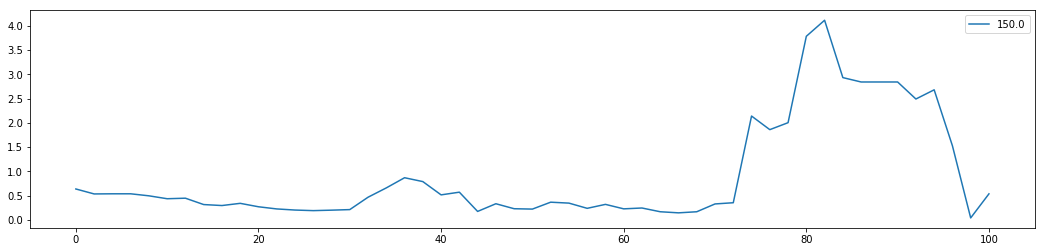

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
156.0
0.538908032473


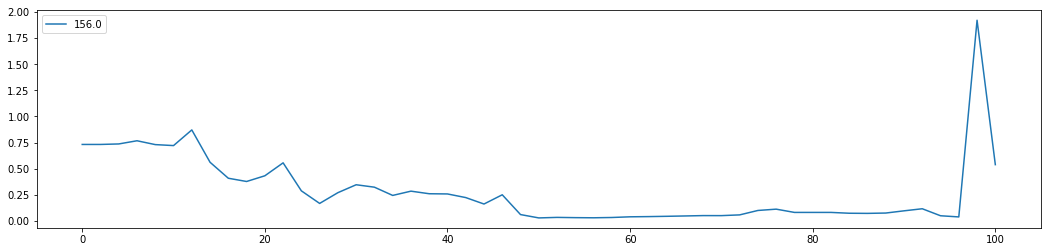

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
162.0
0.538908032473


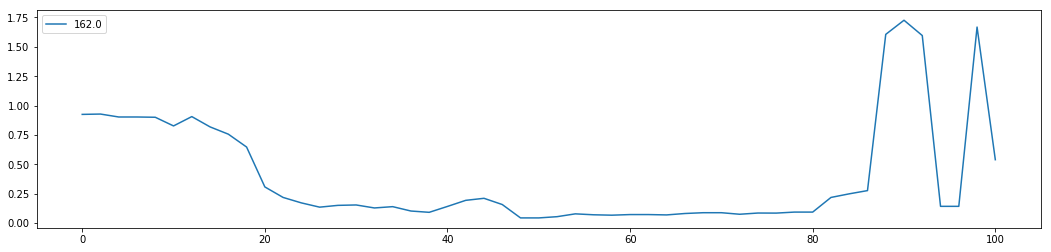

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
168.0
0.538908032473


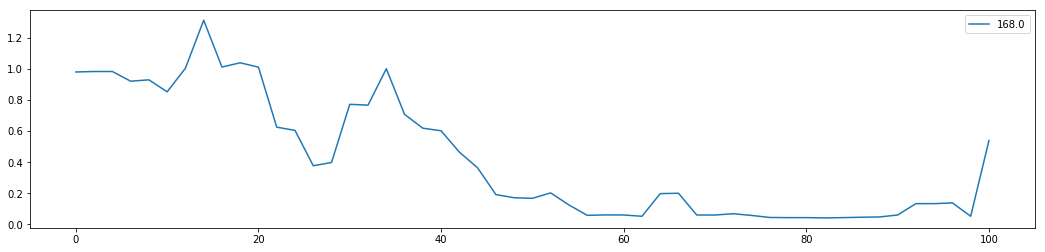

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
174.0
0.538908032473


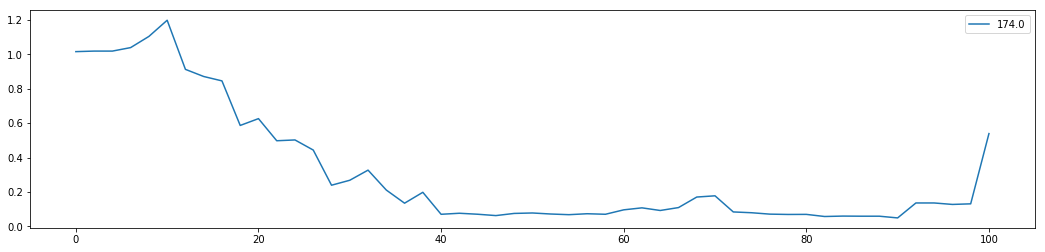

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
180.0
0.538908032473


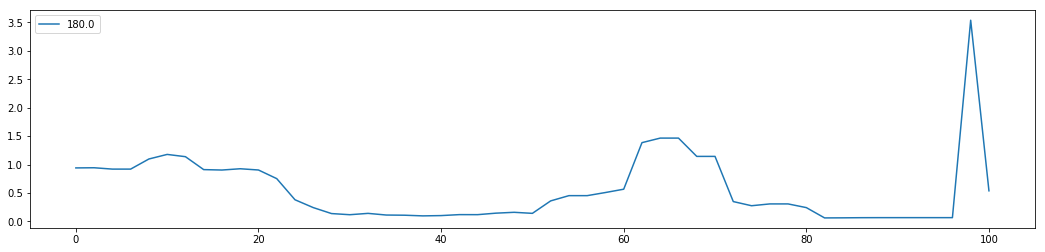

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
186.0
0.538908032473


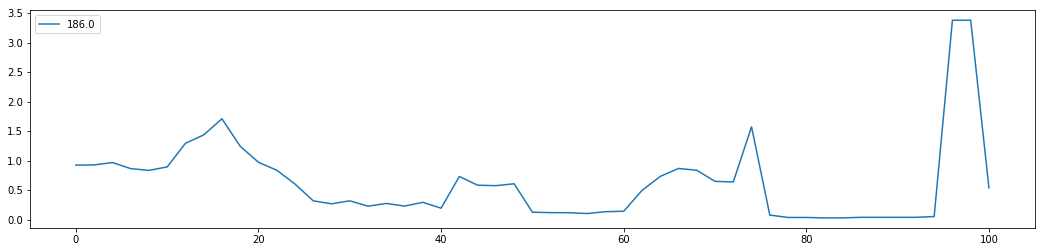

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
192.0
0.538908032473


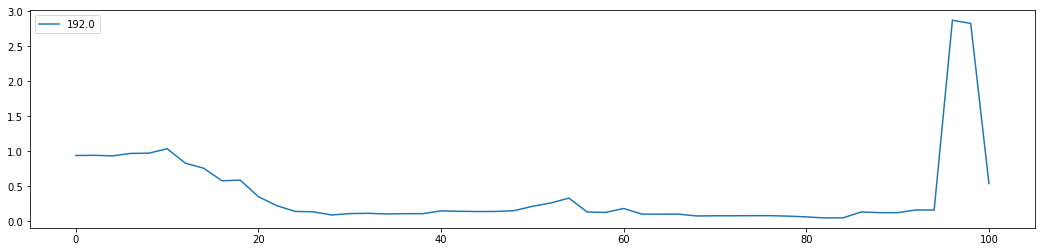

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
198.0
0.538908032473


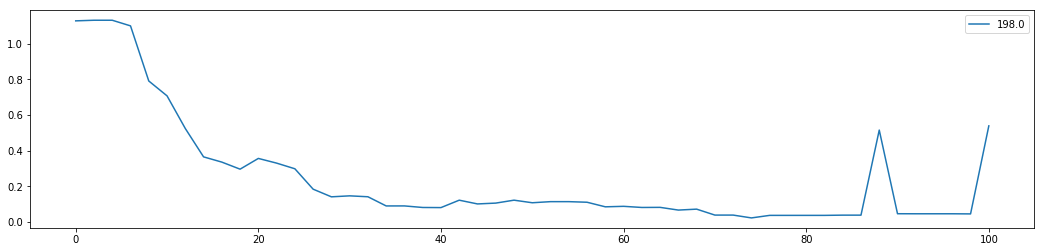

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
204.0
0.538908032473


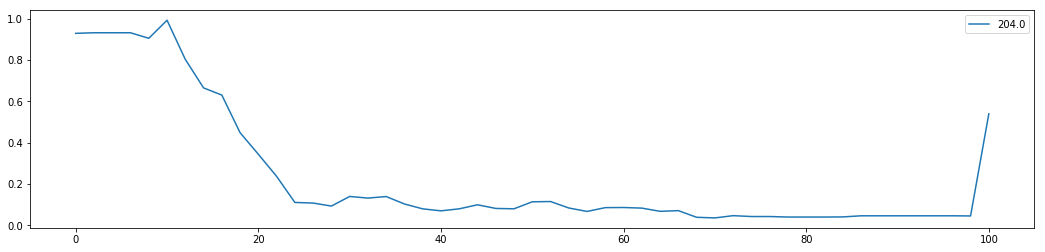

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
210.0
0.538908032473


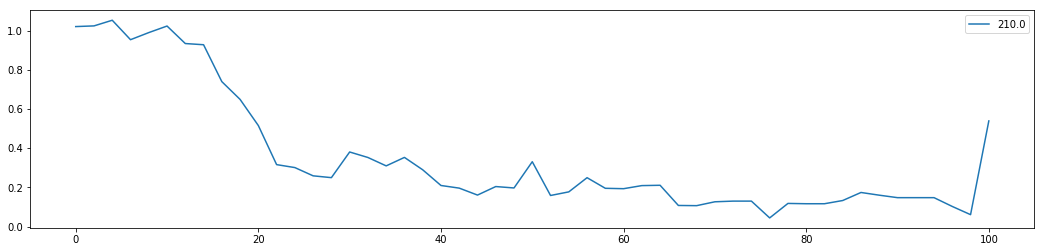

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
216.0
0.538908032473


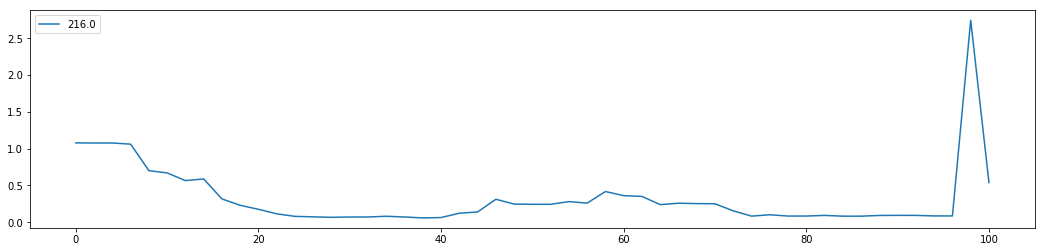

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
222.0
0.538908032473


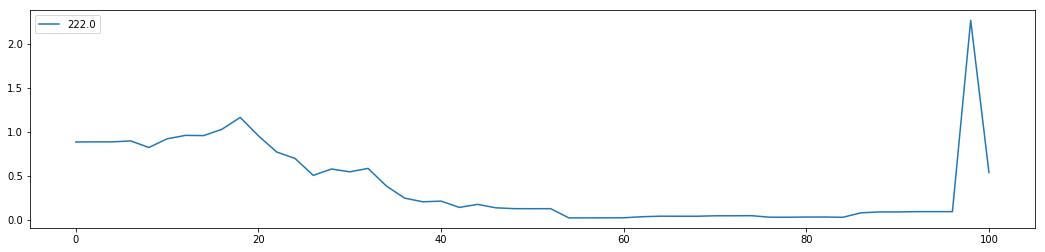

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
228.0
0.538908032473


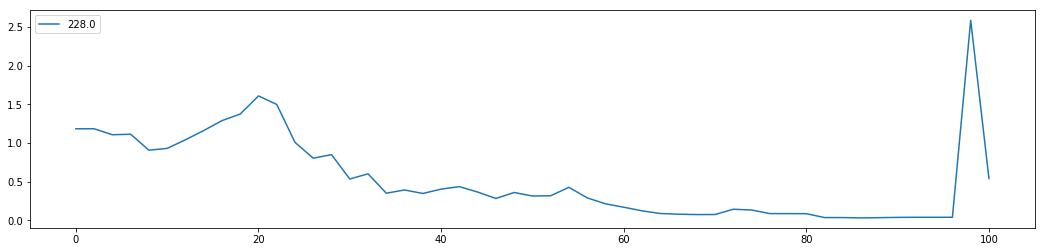

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
234.0
0.538908032473


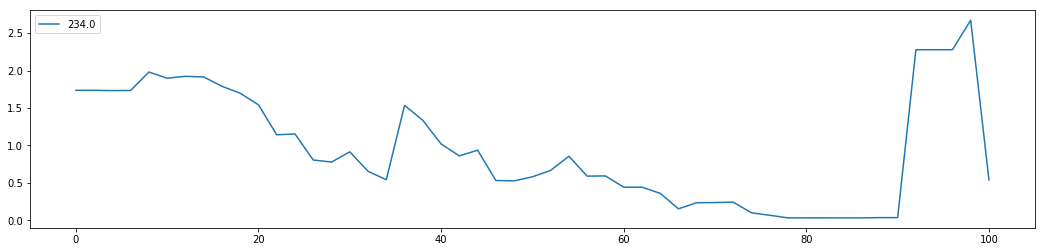

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
240.0
0.538908032473


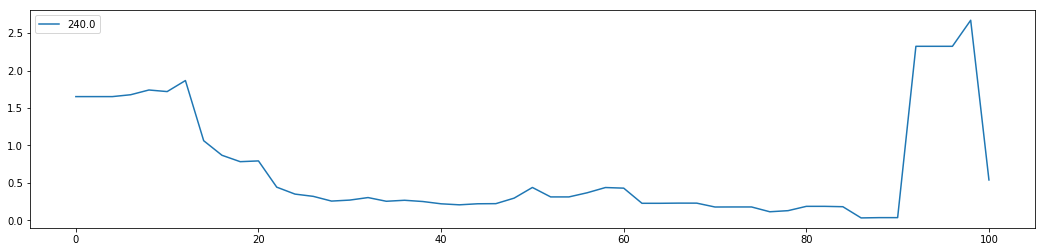

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
246.0
0.538908032473


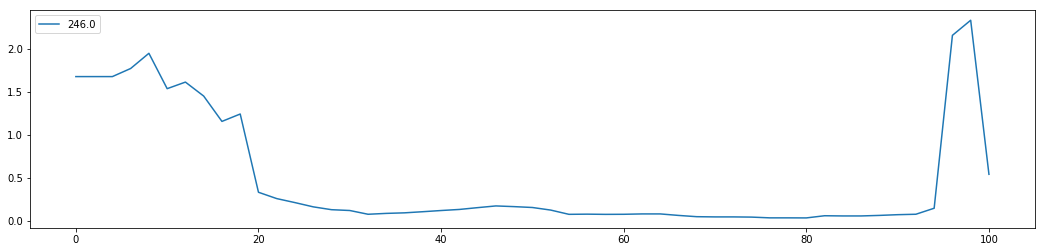

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
252.0
0.538908032473


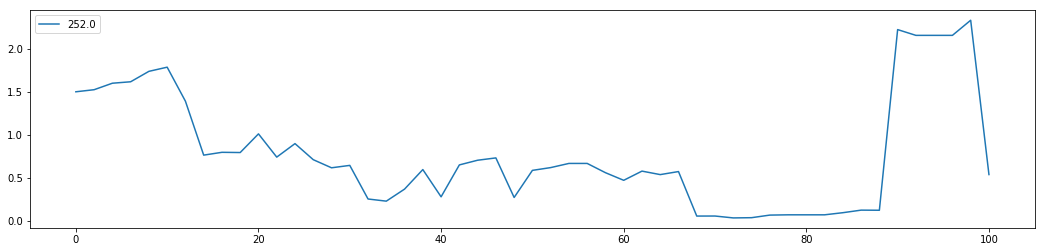

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
258.0
0.538908032473


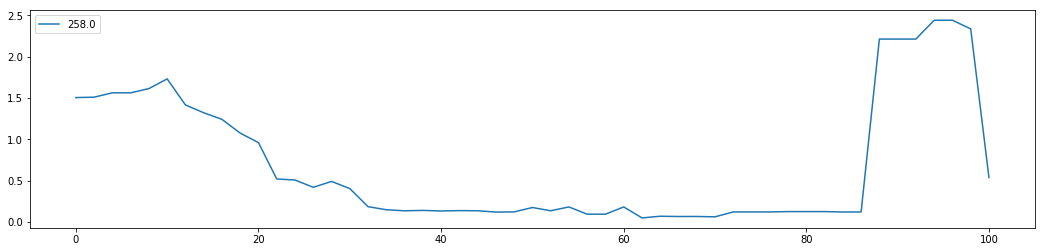

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
264.0
0.538908032473


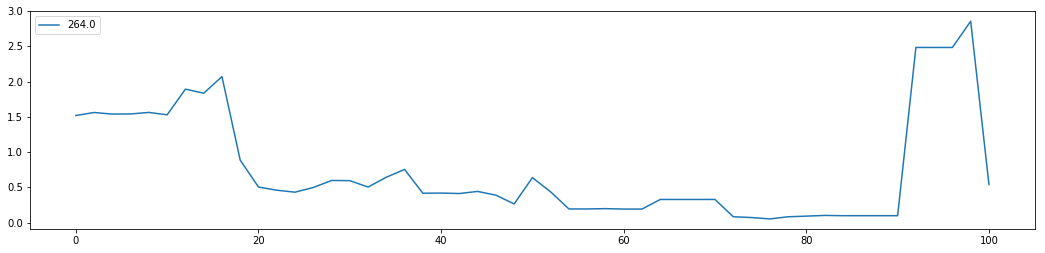

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
270.0
0.538908032473


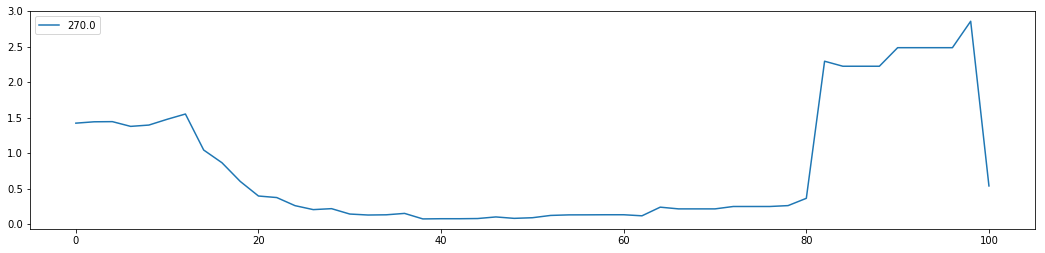

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
276.0
0.538908032473


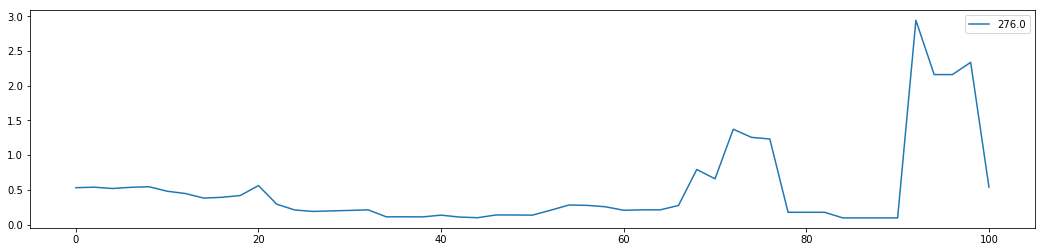

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
282.0
0.538908032473


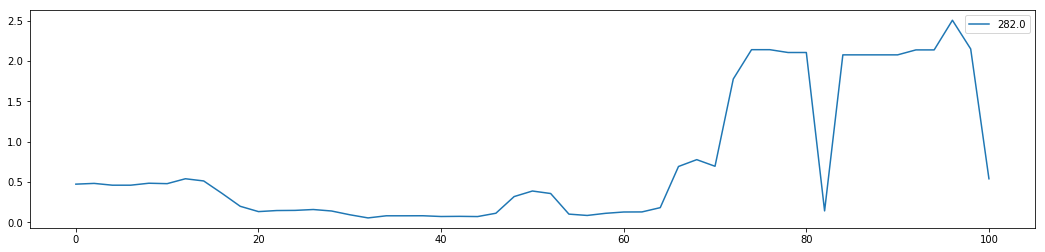

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
288.0
0.538908032473


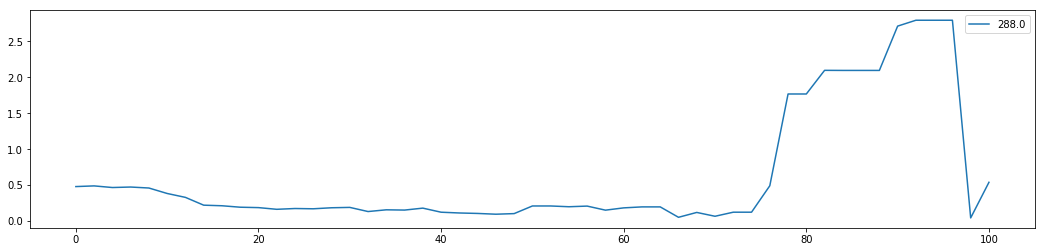

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
294.0
0.538908032473


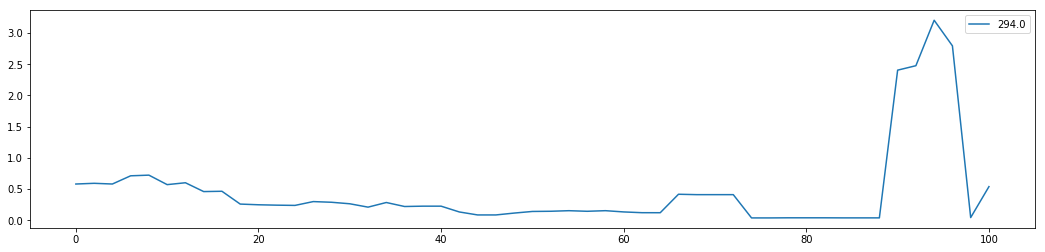

0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0
300.0
0.538908032473


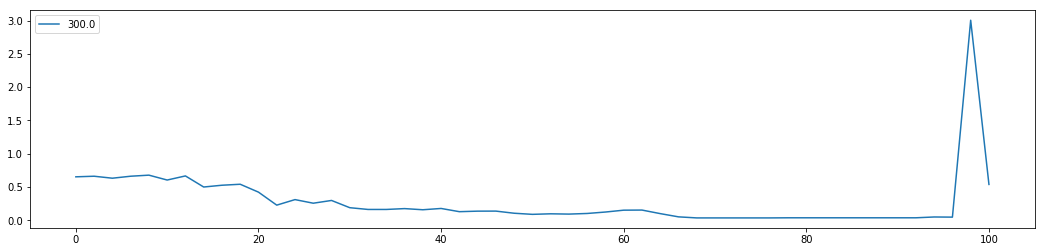

In [5]:
fee = 0.003


windows = np.linspace(6, 300, 50)
longer = 40/6.

frequencies = ['5min','15min','30min','60min','90min','120min','180min']
adx_array = np.linspace(0, 100, 51)

profit = {}
# for f in frequencies:
for window in windows:
    df = resample_df(df0, '5min', int(window), int(window*longer))
    profit_adx = []
    for adx in adx_array:
        print(adx)
        BTC = 1/2
        PLN = df['price'][0]/2
        buy_price = df['price'][0]
        sell_price = df['price'][0]

        old_sma_short = 0
        old_sma_long = 0
        for index, row in df.iterrows():    
            if(old_sma_short < old_sma_long and row['sma_short'] >= row['sma_long'] and row['adx'] > adx):
                if(row['price']/buy_price < 1.2):
#                     print(index, "buy", BTC + PLN/row['price']*(1-fee))
                    BTC = BTC + PLN/row['price']*(1-fee)
                    PLN = 0
                    buy_price = row['price']
                else:
                    buy_price = row['price']
            elif(old_sma_short > old_sma_long and row['sma_short'] <= row['sma_long'] and row['adx'] > adx):
                if(row['price']/sell_price > 0.8):
#                     print(index, "sell", PLN + BTC*row['price']*(1-fee))
                    PLN = PLN + BTC*row['price']*(1-fee)
                    BTC = 0
                    sell_price = row['price']                
                else:
                    sell_price = row['price']

            old_sma_short = row['sma_short']
            old_sma_long = row['sma_long']

        profit_adx.append(PLN/df['price'][-1]+BTC)
        
    profit[window] = profit_adx    

    print(window)
    print(PLN/df['price'][-1]+BTC)
    
    
    plt.plot(adx_array, profit[window], label=window)
    plt.legend()
    plt.show()




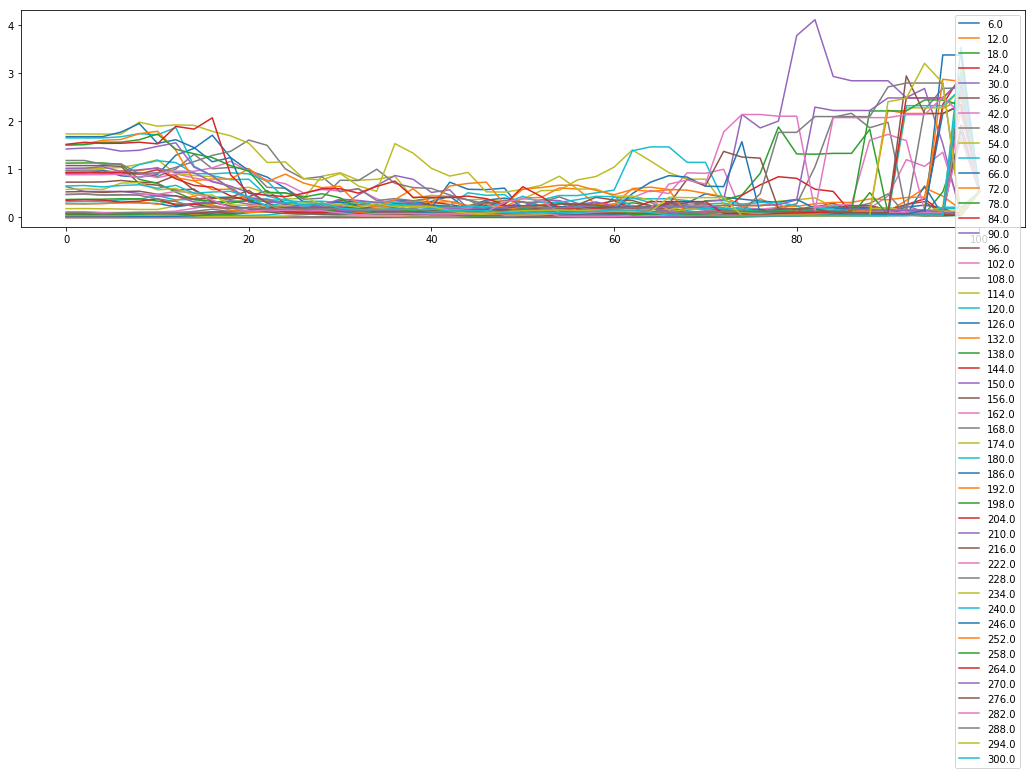

In [6]:
for window in windows:
    plt.plot(adx_array, profit[window], label=window)
plt.legend()
plt.show()

In [7]:
for window in windows:
    print(window, max(profit[window]))

6.0 1.79494721121
12.0 0.612033070955
18.0 1.6531289076
24.0 0.538908032473
30.0 0.538908032473
36.0 0.538908032473
42.0 1.35555534029
48.0 0.538908032473
54.0 0.538908032473
60.0 0.538908032473
66.0 0.650509940922
72.0 2.4665573859
78.0 0.538908032473
84.0 0.538908032473
90.0 0.538908032473
96.0 0.538908032473
102.0 1.00108376432
108.0 2.6918395745
114.0 3.13259859402
120.0 0.538908032473
126.0 0.538908032473
132.0 0.627325069186
138.0 1.88049105925
144.0 2.94909483592
150.0 4.1116874917
156.0 1.92143946365
162.0 1.72606337876
168.0 1.31227412195
174.0 1.19721469384
180.0 3.5377926526
186.0 3.37769178891
192.0 2.87256801782
198.0 1.13160822249
204.0 0.991611698133
210.0 1.05256380696
216.0 2.74470212671
222.0 2.26752241267
228.0 2.58758254473
234.0 2.67149213943
240.0 2.67149213943
246.0 2.33675875152
252.0 2.33675875152
258.0 2.44122247007
264.0 2.85593773578
270.0 2.85593773578
276.0 2.94131097355
282.0 2.50378390935
288.0 2.79410941031
294.0 3.20418676316
300.0 3.00426512462


In [8]:
print(profit[288])

[0.47941355102241645, 0.48880714691881483, 0.46622791347660841, 0.47300718494154487, 0.45935872644599501, 0.38333856161700208, 0.32907815777521815, 0.22056955203254006, 0.21246589958678835, 0.19224353234029426, 0.18661763291851258, 0.16306714159535146, 0.17405340535206304, 0.17031135870043562, 0.18449413172848869, 0.18967156244839692, 0.13197289889085892, 0.15605111230328086, 0.15237371549980816, 0.17938663894998247, 0.12269069023294124, 0.11194218436879115, 0.10553990288656928, 0.094815677150564687, 0.10317850562391069, 0.20938526837706764, 0.20938526837706764, 0.19876106728380741, 0.20777559023082459, 0.15121551920150067, 0.18308751085144945, 0.19668409565278971, 0.19668409565278971, 0.051899218257885044, 0.11950851902792459, 0.066223073084677106, 0.12287729283097619, 0.12287729283097619, 0.49087515772738111, 1.7678435445250682, 1.7678435445250682, 2.0969872267047021, 2.0958350359207985, 2.0958350359207985, 2.0958350359207985, 2.7123512890544701, 2.7941094103106852, 2.794109410310685

In [9]:
fee = 0.003


windows = np.linspace(6, 300, 50)
longer = 40/6.

frequencies = ['5min','15min','30min','60min','90min','120min','180min']
adx_array = np.linspace(0, 100, 51)

profit = {}
# for f in frequencies:
# for window in windows:
df = resample_df(df0, '5min', 288, int(288*longer))
profit_adx = []
for adx in [0.]:
    print(adx)
    BTC = 1/2
    PLN = df['price'][0]/2
    buy_price = df['price'][0]
    sell_price = df['price'][0]

    old_sma_short = 0
    old_sma_long = 0
    for index, row in df.iterrows():    
        if(old_sma_short < old_sma_long and row['sma_short'] >= row['sma_long'] and row['adx'] > adx):
            if(row['price']/buy_price < 1.2):
                print(index, "buy", BTC + PLN/row['price']*(1-fee))
                BTC = BTC + PLN/row['price']*(1-fee)
                PLN = 0
                buy_price = row['price']
            else:
                buy_price = row['price']
        elif(old_sma_short > old_sma_long and row['sma_short'] <= row['sma_long'] and row['adx'] > adx):
            if(row['price']/sell_price > 0.8):
                print(index, "sell", PLN + BTC*row['price']*(1-fee))
                PLN = PLN + BTC*row['price']*(1-fee)
                BTC = 0
                sell_price = row['price']                
            else:
                sell_price = row['price']
            
        old_sma_short = row['sma_short']
        old_sma_long = row['sma_long']

    profit_adx.append(PLN/df['price'][-1]+BTC)

profit[window] = profit_adx    

print(window)
print(PLN/df['price'][-1]+BTC)

0.0
2014-04-14 21:25:00 buy 2.08559036145
2014-05-02 02:25:00 buy 2.08559036145
2014-05-03 00:10:00 sell 2826.62009107
2014-05-08 08:10:00 buy 2.10662697125
2014-05-12 05:50:00 sell 2782.9068947
2014-05-14 21:15:00 buy 2.05484774969
2014-05-18 21:15:00 sell 2725.77300617
2014-05-20 08:40:00 buy 1.9831760255
2014-05-29 21:10:00 sell 3331.62664816
2014-06-09 21:40:00 sell 3331.62664816
2014-06-10 11:35:00 buy 1.69832046096
2014-06-11 17:00:00 sell 3281.47101817
2014-06-17 16:55:00 buy 1.81079918538
2014-06-20 20:55:00 sell 3239.42980628
2014-06-21 03:15:00 buy 1.79878112886
2014-06-21 08:25:00 sell 3202.98522685
2014-06-23 06:20:00 buy 1.75556694402
2014-06-23 14:15:00 sell 3120.7853336
2014-06-28 01:45:00 buy 1.73822512715
2014-07-06 09:15:00 sell 3271.92373294
2014-07-08 07:55:00 sell 3271.92373294
2014-07-13 00:50:00 buy 1.73331985215
2014-07-14 22:25:00 sell 3228.38717734
2014-07-18 10:30:00 buy 1.66114223711
2014-07-22 10:45:00 sell 3095.36081663
2014-08-01 12:55:00 buy 1.6956454583

2017-05-15 22:15:00 sell 13829.4619737
2017-05-27 14:20:00 sell 13829.4619737
2017-06-13 07:50:00 sell 13829.4619737
2017-06-20 16:15:00 buy 1.37248354235
2017-06-25 00:35:00 sell 13403.3442815
2017-07-03 15:15:00 buy 1.39488822203
2017-07-08 04:00:00 sell 13097.3123344
2017-07-18 15:25:00 buy 1.52175494315
2017-07-25 23:25:00 sell 14054.2365989
2017-07-28 14:45:00 buy 1.41153384345
2017-08-03 00:30:00 sell 13786.4557388
2017-08-04 09:25:00 buy 1.37449411011
2017-08-19 16:35:00 sell 20491.3796896
2017-09-04 15:15:00 sell 20491.3796896
2017-09-06 20:45:00 buy 1.207793678
2017-09-08 13:55:00 sell 19571.9264065
2017-09-18 14:05:00 buy 1.27706903831
2017-09-21 19:10:00 sell 17050.6783435
2017-09-25 22:10:00 buy 1.19420627387
2017-10-05 04:15:00 sell 18218.6888293
2017-10-06 00:45:00 buy 1.14954957046
2017-10-18 15:30:00 sell 21791.7442119
2017-10-24 17:00:00 sell 21791.7442119
2017-10-26 21:10:00 buy 1.0265742398
2017-11-09 15:25:00 sell 27107.7652918
2017-12-20 18:55:00 sell 27107.7652918

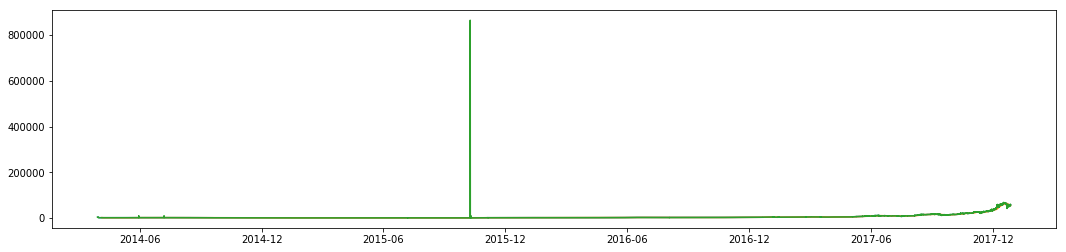

In [10]:
plt.plot(df['sma_short'])
plt.plot(df['sma_long'])
plt.plot(df['close'])
plt.show()